In [1]:
import numpy as np
np.set_printoptions(precision=5)

from scipy.linalg import block_diag
from scipy.integrate import ode
from scipy.optimize import minimize

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib import Lowpass, DoubleExp

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='white')
%matplotlib inline

import pandas as pd


import time
import warnings

import neuron
neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
neuron.h.load_file('stdrun.hoc')

	1 


1.0

## Neuron Types

In [2]:
class AdaptiveLIFT(LIFRate):
    
    '''
    Aaron Voelker
    https://github.com/nengo/nengo/issues/1423
    '''
    
    probeable = ('spikes', 'voltage', 'refractory_time', 'threshold')

    min_voltage = NumberParam('min_voltage', high=0)
    tau_adapt = NumberParam('tau_adapt', low=0)
    inc_adapt = NumberParam('inc_adapt', low=0)

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0,
                 amplitude=1, tau_adapt=0.1, inc_adapt=0.05):
        super(AdaptiveLIFT, self).__init__(
            tau_rc=tau_rc, tau_ref=tau_ref, amplitude=amplitude)
        self.min_voltage = min_voltage
        self.tau_adapt = tau_adapt
        self.inc_adapt = inc_adapt
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(gain)
        refractory_time = np.zeros_like(gain)
        threshold = np.ones_like(gain)

        return settled_firingrate(
            self.step_math, J, [voltage, refractory_time, threshold],
            dt=0.001, settle_time=0.3, sim_time=1.0)
    
    def gain_bias(self, max_rates, intercepts):
        return NeuronType.gain_bias(self, max_rates, intercepts)

    def max_rates_intercepts(self, gain, bias):
        return NeuronType.max_rates_intercepts(self, gain, bias)

    def step_math(self, dt, J, spiked, voltage, refractory_time, threshold):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = threshold and solve for t to compute the spike time
        # TODO: not sure if this mask is the right way to handle log domain errors
        threshold_spiked = threshold[spiked_mask]
        m = (voltage[spiked_mask] - threshold_spiked) / (J[spiked_mask] - threshold_spiked)
        t_spike = np.zeros_like(m)
        t_spike[m < 1] = dt + self.tau_rc * np.log1p(-m[m < 1])

        # update threshold using discretized lowpass filter
        # applied to the input 1 + spiked * inc_adapt 
        threshold -= ((1 + self.inc_adapt * spiked - threshold) *
                      np.expm1(-dt / self.tau_adapt))
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike


@Builder.register(AdaptiveLIFT)
def build_alift(model, lif, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.zeros(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['refractory_time'] = Signal(
        np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
    model.sig[neurons]['threshold'] = Signal(
        np.ones(neurons.size_in), name="%s.threshold" % neurons)
    model.add_op(SimNeurons(
        neurons=lif,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['refractory_time'],
                model.sig[neurons]['threshold']]))

In [3]:
class WilsonEuler(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonEuler, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args


    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        J_steps = 201  # Odd number so that 0 is a sample
        max_rate = max_rates.max()
        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
#             print('J', J, 'euler rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)
        AP = np.zeros_like(J, dtype=bool)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance, AP],
            dt=0.00005, settle_time=0.1, sim_time=1.0)


    def step_math(self, dt, J, spiked, V, R, H, AP):
        if np.abs(J).any() >= 2.0:
            warnings.warn("input current exceeds failure point; clipping")
            J = J.clip(max=self._maxJ)
        dV = -(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) - 26*R*(V + 0.95) - 13*H*(V + 0.95) + J
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        
        V[:] = (V + dV * dt/self.tau_V).clip(-0.9, 0.3)
        R[:] = (R + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        H[:] = (H + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (V > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = V > self.threshold
        return spiked, V, R, H, AP


@Builder.register(WilsonEuler)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

In [4]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA  # dopaminergic modulation ON/OFF
        self.max_rates = np.array([])
        self.intercepts = np.array([])
        
    def gain_bias(self, max_rates, intercepts):
        return np.ones_like(max_rates), np.zeros_like(intercepts)
        
    def max_rates_intercepts(self, gain, bias):
        """Measure firing rate at each eval_point using neuron_rates, estimate x_int and rate at y_int"""
        return self.max_rates, self.intercepts
    
    def step_math(self, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = voltage.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        if neuron.h.t < time*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        for n in range(n_neurons):
            if not np.isfinite(v_recs[n][-1]):
#                 warnings.warn('neuron %s returned nan voltage at t=%s' %(n, neuron.h.t*1000))
                voltage[n] = 0
            else:
                voltage[n] = v_recs[n][-1]
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        n_neurons=neurons.size_in,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = neuronop.neurons
    model.add_op(neuronop)
    
class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, n_neurons,  J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = [neuron.h.Durstewitz() for n in range(n_neurons)]
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(n_neurons)]
        for n in range(n_neurons):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before,
                voltage, output, time, dt)
        return step_nrn
    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]

class TransmitSpikes(Operator):
    def __init__(self, neurons, taus, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.taus = taus
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        self.synapses = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                self.synapses[pre, post] = []
                for loc in [self.neurons[post].basal(0.5),
                            self.neurons[post].prox(0.5),
                            self.neurons[post].dist(0.5)]:
                    if len(self.taus) == 1:
                        syn = neuron.h.ExpSyn(loc)
                        syn.tau = self.taus[0]*1000
                    elif len(taus) == 2:
                        syn = neuron.h.Exp2Syn(loc)
                        syn.tau1 = np.min(self.taus)*1000
                        syn.tau2 = np.max(self.taus)*1000
                    syn.e = 0.0 if self.weights[pre, post] > 0 else -70.0
                    self.synapses[pre, post].append(syn)
#         self.netcons = np.zeros((1,1), dtype=list)
#         self.stim = neuron.h.NetStim()
#         self.syn = neuron.h.ExpSyn(self.neurons[0].soma(0.5))
#         self.syn.tau = 100
#         self.netcons[0,0] = [neuron.h.NetCon(None, self.syn, 0, 0, 1e-3)]
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = np.abs(self.weights[pre, post])
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    nc.active(0)  # turn off until build finishes
                    self.netcons[pre, post].append(nc)
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = time.item()*1000
#             if int(t_neuron) % 10 == 0:
#                 for nc in self.netcons[0,0]:
#                     nc.event(t_neuron)
#                 for pre in range(spikes.shape[0]):
#                     for post in range(len(self.neurons)):
#                         for nc in self.netcons[pre, post]:
#                             nc.event(t_neuron)
            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
#                 if int(t_neuron) % 10 == 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step

    @property
    def spikes(self):
        return self.reads[0]
    
class BiasSpikes(Operator):
    def __init__(self, neurons, bias):
        super(BiasSpikes, self).__init__()
        self.neurons = neurons
        self.tau = 0.1
        self.bias = bias
        self.reads = []
        self.updates = []
        self.sets = []
        self.incs = []
        self.stims = []
        self.syns = []
        self.ncs = []
        for n in range(len(self.neurons)):
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                self.stims.append(neuron.h.NetStim())
                self.syns.append(neuron.h.ExpSyn(loc))
                self.syns[-1].tau = self.tau * 1000  # time constant of synapse on spiking bias input
                self.syns[-1].e = 0.0 if self.bias[n] > 0 else -70.0
                self.ncs.append(neuron.h.NetCon(self.stims[-1], self.syns[-1], 0, 0, np.abs(self.bias[n])))
                self.ncs[-1].pre().start = 0
                self.ncs[-1].pre().number = 1e10
                self.ncs[-1].pre().interval = 1
                self.ncs[-1].pre().noise = 0  # 0 for regular spikes at rate, 1 for poisson spikes at rate
                self.ncs[-1].active(0)  # turn off until build finishes
    def make_step(self, signals, dt, rng):
        def step():
            pass
        return step

@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):
        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"
        assert 0 < len(conn.synapse.den) <= 2, "only exponential and double exponential synapses supported"
        
        # load previously optimized gain/bias
        taus = -1.0/np.array(conn.synapse.poles)
        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        encoders = model.params[conn.post_obj].encoders
        if hasattr(conn, 'gain') and conn.gain is not 0:
            gain = conn.gain
            bias = conn.bias
        else:
            gain = 1e-10*np.ones((conn.post_obj.n_neurons))
            bias = np.zeros((conn.post_obj.n_neurons))
        gain = np.array(gain.reshape((encoders.shape[0], 1)))

        # normalize by area under synapse curve, integral PSC(t) |b-a = F(b) - F(a), b=1s, a=0s
        tf = 10.0
        if len(taus) == 1:
            gain /= (taus[0] * (-np.exp(-tf/taus[0]) + 1))
        elif len(taus) == 2:
            gain /= np.max(taus)/(np.max(taus)-np.min(taus)) * \
                (np.min(taus) + np.max(taus) - \
                 np.min(taus)*np.exp(-tf/np.min(taus)) - np.max(taus)*np.exp(-tf/np.max(taus)))
            
        # connect spiking poisson input to conn.post, if one doesn't already exist
        if not hasattr(conn, 'biasspike'):
            biasspike = BiasSpikes(model.params[conn.post_obj.neurons], bias)
            model.add_op(biasspike)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                conn.biasspike = biasspike
        
        # connect spikes from conn.pre to conn.post with computed weight matrix       
        scaled_enc = encoders * gain
        weights = np.dot(d.T, scaled_enc.T)
        transmitspike = TransmitSpikes(model.params[conn.post_obj.neurons], taus, weights,
            model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt)
        model.add_op(transmitspike)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            conn.transmitspike = transmitspike
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    
    else:
        return nengo.builder.connection.build_connection(model, conn)

def reset_neuron(sim):
    for key in list(sim.model.params.keys()):
        if type(key) == nengo.ensemble.Neurons:
            del(sim.model.params[key])
    for op in sim.model.operators:
        if isinstance(op, SimNeuronNeurons):
            for v_rec in op.v_recs:
                v_rec.play_remove()
            for spk_vec in op.spk_vecs:
                spk_vec.play_remove()
            del(op.neurons)
        if isinstance(op, BiasSpikes):
            del(op.neurons)
            del(op.ncs)
        if isinstance(op, TransmitSpikes):
            del(op.neurons)
            del(op.netcons)


/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


## Optimization and RMSE

In [5]:
def norms(t, dt=0.001, stim_func=lambda t: np.cos(t)):
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        p_stimulus = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    norm_stim = np.max(np.abs(sim.data[p_stimulus]))
    norm_int = np.max(np.abs(sim.data[p_integral]))
    return norm_stim, norm_int

def update_d(target, spk, h, h_tar, lambda_d=1e-1,  dt=0.001):
    target = h_tar.filt(target, dt=dt)
    A = h.filt(spk, dt=dt)
    d_new = LstsqL2(reg=lambda_d)(A, target)[0]
    return d_new

def update_h_lstsq(stim, target, spikes,
        lambda_c=1e-1, lambda_d=1e-1, order=1, n_samples=10000,
        min_d=-1e-2, max_d=1e-2, dt=0.001, tau=0.1, 
        mean_taus=[1e-1, 1e-3], std_taus=[1e-2, 1e-5], max_tau=1e0, maxiter=100):
    
    """Courtesy of Aaron Voelker"""
    mean_taus = np.array(mean_taus)[:order]
    std_taus = np.array(std_taus)[:order]

    def sample_prior(n_samples, order, mean_taus, std_taus, min_tau=1e-5, rng=np.random.RandomState(seed=0)):
        """Return n samples (taus) from the prior of a k'th-order synapse."""
        taus = np.zeros((n_samples, order))
        for o in range(order):
            taus[:, o] = rng.normal(mean_taus[o], std_taus[o], size=(n_samples, )).clip(min_tau)
        return taus
    
    for iter in range(maxiter):  # maxiter
        assert len(mean_taus) == order
        assert len(std_taus) == order
        taus = sample_prior(n_samples, order, mean_taus, std_taus)

        poles = -1. / taus
        n_steps = spikes.shape[0]
        n_neurons = spikes.shape[1]
        assert poles.shape == (n_samples, order)

        tf_params = np.zeros((n_samples, order))
        for i in range(n_samples):
            sys = LinearSystem(([], poles[i, :], 1 / np.prod(taus[i, :])))   # (zeros, poles, gain)
            assert len(sys) == order
            assert np.allclose(sys.dcgain, 1)
            den_normalized = np.asarray(sys.den / sys.num[0])
            assert len(den_normalized) == order + 1
            assert np.allclose(den_normalized[-1], 1)  # since normalized
            # tf_params ordered from lowest to highest, ignoring c_0 = 1, i.e., [c_1, ..., c_k]
            tf_params[i, :] = den_normalized[:-1][::-1]

        # We assume c_i are independent by setting the off-diagonals to zero
        C = np.cov(tf_params, rowvar=False)
        if order == 1:
            C = C*np.eye(1)
        Q = np.abs(np.linalg.inv(C))
        c0 = np.mean(tf_params, axis=0)
        d0 = np.ones((n_neurons, ))
        cd0 = np.hstack((c0, d0))
        assert Q.shape == (order, order)
        assert cd0.shape == (order+n_neurons,)

        diff = (1. - ~z) / dt
        A = np.zeros((n_steps, order + n_neurons))
        deriv_n = target
        for i in range(order):
            deriv_n = diff.filt(deriv_n, dt=dt)
            A[:, i] = deriv_n.ravel()  # todo: D>1
        for n in range(n_neurons):
            A[:, order+n] = spikes[:, n]
        b = tau  # set on pre_u ==> supv connection in network
        Y = (b*stim - target)
        smoother = Lowpass(tau)
        A = smoother.filt(A, dt=dt, axis=0)
        Y = smoother.filt(Y, dt=dt)

        # construct block diagonal matrix with different regularizations for filter coefficients and decoders
        L = block_diag(lambda_c*Q, lambda_d*np.eye(n_neurons))
        gamma = A.T.dot(A) + L
        upsilon = A.T.dot(Y) + L.dot(cd0).reshape((order+n_neurons, 1))  # optional term with tikhonov regularization

        cd = np.linalg.inv(gamma).dot(upsilon).ravel()
        c_new = cd[:order]
        d_new = -1.*cd[-n_neurons:]
        assert c_new.shape==(order,)
        assert d_new.shape==(n_neurons,)
        print('taus iteration %s, nonzero d %s, tau=%s: '%(iter, np.count_nonzero(d_new+1), c_new))
        for n in range(n_neurons):
            if d_new[n] > max_d or d_new[n] < min_d:
                d_new[n] = 0
        d_new = d_new.reshape((n_neurons, 1))
        if order == 1:
            h_new = Lowpass(c_new[0])
        elif order == 2:
            h_new = DoubleExp(c_new[0], c_new[1])
#         h_new = 1. / (1 + sum(c_new[i] * s**(i+1) for i in range(order)))
        assert np.allclose(h_new.dcgain, 1)
        if np.all(c_new > 0):
            break
        else:
            mean_taus[np.argmin(mean_taus)] *= 1.25
            lambda_c *= 1.25
            lambda_d *= 1.25

    return h_new, d_new

def update_h_hyperopt(target, spikes, order=1, maxiter=100, seed=0, dt=0.001,
        tau_mins=[0.05, 0.001], tau_maxs=[0.2, 0.01], reg_min=1e-1, reg_max=1e-1):

    np.savez('spk.npz', spikes=spikes)
    np.savez('tar.npz', target=target)
    
    hyperparams = {}
    hyperparams['order'] = order
    hyperparams['dt'] = dt
    for o in range(order):
        hyperparams[str(o)] = hp.uniform(str(o), tau_mins[o], tau_maxs[0])
#     hyperparams['reg'] = hp.uniform('reg', reg_min, reg_max)
    hyperparams['reg'] = reg_min

    def objective(hyperparams):
        if hyperparams['order'] == 1:
            taus = [hyperparams['0']]
            h = Lowpass(taus[0])
        elif hyperparams['order'] == 2:
            taus = [hyperparams['0'], hyperparams['1']]
            h = DoubleExp(taus[0], taus[1])
        reg = hyperparams['reg']
        spk = np.load('spk.npz')['spikes']
        act = h.filt(spk, dt=hyperparams['dt'])
        tar = np.load('tar.npz')['target']
        d = LstsqL2(reg=reg)(act, tar)[0]
        xhat = np.dot(act, d)
        loss = nrmse(xhat, target=tar)
        return {'loss': loss, 'taus': taus, 'reg': reg, 'status': STATUS_OK }
    
    trials = Trials()

    fmin(objective,
        rstate=np.random.RandomState(seed=seed),
        space=hyperparams,
        algo=tpe.suggest,
        max_evals=maxiter,
        trials=trials)
    best_idx = np.argmin(trials.losses())
    best = trials.trials[best_idx]

    if order == 1:
        h_new = Lowpass(best['result']['taus'][0])
    elif order == 2:
        h_new = DoubleExp(best['result']['taus'][0], best['result']['taus'][1])
    d_new = LstsqL2(reg=best['result']['reg'])(h_new.filt(spikes, dt=dt), target)[0]
        
    return h_new, d_new

In [6]:
def conn_opt(conns, t=4*np.pi, seed=0, maxiter=10, stim_func=lambda t: np.sin(t), dt=0.001, tau_smooth=0.1,
        t_trans=0.25, pt=False, neurons_per_plot=5, mean_thr=2, bins=20, delta_gain=1e-4, delta_bias=2e-5, tol=0.01):
    gain_bias_dict = dict()
    for conn in conns:
        print(conn)
        n_neurons = conn.post_obj.n_neurons
        nrn_idx = list(np.arange(n_neurons))
        norm_stim, norm_int = norms(t, dt=dt, stim_func=stim_func)
        y_max = conn.post_obj.max_rates.high
        gain_bias_dict[conn.label] = {'gain': 1e-10*np.ones((n_neurons)), 'bias': np.zeros((n_neurons))}
        gain = 1e-4 * np.ones((n_neurons)) *conn.pre_obj.max_rates.low
        bias = np.zeros((n_neurons))
        trimmed_gain = gain
        trimmed_bias = bias
        trimmed_max_rates = conn.post_obj.max_rates
        trimmed_intercepts = conn.post_obj.intercepts
        trimmed_encoders = conn.post_obj.encoders
        if (isinstance(conn.solver, NoSolver) and np.count_nonzero(conn.solver.values) == 0):
            solver = LstsqL2(reg=1e-1)
        else:
            solver = conn.solver
        for i in range(maxiter):
            if len(nrn_idx) == 0:
                break
            print('iteration %s, remaining neurons %s' %(i, len(nrn_idx)))
            with nengo.Network(seed=seed) as net:
                net.T = t
                def flip(t, x):
                    if t<net.T/2: return x/norm_stim
                    elif t>=net.T/2: return -1.0*x/norm_stim
                u_raw = nengo.Node(stim_func)
                stim = nengo.Node(output=flip, size_in=1)
                pre = nengo.Ensemble(
                    conn.pre_obj.n_neurons,
                    conn.pre_obj.dimensions,
                    neuron_type=nengo.LIF(),
                    max_rates=conn.pre_obj.max_rates,
                    intercepts=conn.pre_obj.intercepts,
                    encoders=conn.pre_obj.encoders,
                    seed=conn.pre_obj.seed)
                ens = nengo.Ensemble(
                    len(nrn_idx),
                    conn.post_obj.dimensions,
                    neuron_type=conn.post_obj.neuron_type,
                    max_rates=trimmed_max_rates,
                    intercepts=trimmed_intercepts,
                    encoders=trimmed_encoders,
                    seed=conn.post_obj.seed)
                lif = nengo.Ensemble(
                    len(nrn_idx),
                    conn.post_obj.dimensions,
                    neuron_type=nengo.LIF(),
                    max_rates=trimmed_max_rates,
                    intercepts=trimmed_intercepts,
                    encoders=trimmed_encoders,
                    seed=conn.post_obj.seed)
                nengo.Connection(u_raw, stim, synapse=None)
                nengo.Connection(stim, pre, synapse=None)
                c = nengo.Connection(pre, ens,
                    solver=solver, synapse=conn.synapse, seed=conn.seed)  #  transform=conn.transform,
                c2 = nengo.Connection(pre, lif,
                    solver=solver, synapse=conn.synapse, seed=conn.seed)  #  transform=conn.transform,
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    c.gain = trimmed_gain
                    c.bias = trimmed_bias
                p_stim = nengo.Probe(stim, synapse=tau_smooth)
                p_pre = nengo.Probe(pre, synapse=tau_smooth)
                p_ens = nengo.Probe(ens.neurons, synapse=tau_smooth)
                p_lif = nengo.Probe(lif.neurons, synapse=tau_smooth)
            with nengo.Simulator(net, dt=dt, seed=seed, progress_bar=False) as optsim:
                optsim.run(t, progress_bar=True)
                reset_neuron(optsim) 
            stim = optsim.data[p_stim][int(t_trans/dt):]
            pre = optsim.data[p_pre][int(t_trans/dt):]
            a_ens = optsim.data[p_ens][int(t_trans/dt):]
            a_lif = optsim.data[p_lif][int(t_trans/dt):]
            enc = optsim.data[ens].encoders
            if i == 0:
                trimmed_max_rates = optsim.data[ens].max_rates
                trimmed_intercepts = optsim.data[ens].intercepts
                trimmed_encoders = optsim.data[ens].encoders
            del(net)
            del(optsim)
            
            ens_bins, ens_means, ens_stds = bin_activities_values_1d(
                stim, a_ens, bins=bins, n_neurons=len(nrn_idx))
            lif_bins, lif_means, lif_stds = bin_activities_values_1d(
                stim, a_lif, bins=bins, n_neurons=len(nrn_idx))

            if pt:
                cmap = sns.color_palette()
                fig, ax = plt.subplots(figsize=(8, 8))
                for nrn in range(len(nrn_idx)):
                    ax.plot(ens_bins, ens_means[nrn], c=cmap[nrn])
                    ax.fill_between(ens_bins,
                        ens_means[nrn]+ens_stds[nrn], ens_means[nrn]-ens_stds[nrn], alpha=0.25, facecolor=cmap[nrn])
                    ax.plot(lif_bins, lif_means[nrn], c=cmap[nrn], linestyle='--')
                    ax.set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$', ylabel='a (Hz)')
                    plt.tight_layout()
                plt.show()
            
            to_delete = []
            for n, nrn in enumerate(np.copy(nrn_idx)):
                if np.all(ens_means[n] < mean_thr):
                    trimmed_bias[n] += 0.3 * delta_bias
                    continue
                if np.all(ens_means[n] > y_max):
                    trimmed_bias[n] -= 0.3 * delta_bias
                    continue
                if int(enc[n][0]) == 1:
                    first = 0
                    last = -1
                elif int(enc[n][0]) == -1:
                    first = -1
                    last = 0
                else:
                    raise RuntimeError("encoders must be integers for gain/bias conn opt")
                ens_where = np.where(ens_means[n] <= mean_thr)[0]
                lif_where = np.where(lif_means[n] <= mean_thr)[0]
                if len(ens_where) > 0:
                    x_int_ens_idx = ens_where[last]
                    x_int_ens = ens_bins[x_int_ens_idx]
                else:
                    x_int_ens = ens_bins[first]
                if len(lif_where) > 0:
                    x_int_lif_idx = lif_where[last]
                    x_int_lif = lif_bins[x_int_lif_idx]
                else:
                    x_int_lif = lif_bins[first]
                y_int_ens = ens_means[n][last]
                y_int_lif = lif_means[n][last]
                delta_x = x_int_lif - x_int_ens  # positive ==> x-intercept is too far left
                delta_y = y_int_lif - y_int_ens  # positive ==> max firing rate is too low
                loss = np.square(delta_x) + np.square(delta_y / y_max)
#                 print('gain', trimmed_gain[n])
#                 print('bias', trimmed_bias[n])
#                 print('neuron %s loss %.5f' %(nrn_idx[n], loss))
                if loss < tol:
                    to_delete.append(n)
                    gain[nrn] = trimmed_gain[n]
                    bias[nrn] = trimmed_bias[n]
                    continue
                if delta_x >= 0:
                    trimmed_bias[n] -= delta_bias * np.abs(delta_x) * enc[n]
                else:
                    trimmed_bias[n] += delta_bias * np.abs(delta_x) * enc[n]
                if delta_y >= 0:
                    trimmed_gain[n] += delta_gain * np.abs(delta_y)
                else:
                    trimmed_gain[n] -= delta_gain * np.abs(delta_y)
                trimmed_gain[n] = np.abs(trimmed_gain[n])
            
            trimmed_gain = np.delete(trimmed_gain, to_delete)
            trimmed_bias = np.delete(trimmed_bias, to_delete)
            trimmed_max_rates = np.delete(trimmed_max_rates, to_delete)
            trimmed_intercepts = np.delete(trimmed_intercepts, to_delete)
            trimmed_encoders = np.delete(trimmed_encoders, to_delete, axis=0)
            nrn_idx = np.delete(np.array(nrn_idx), to_delete)
            
        
        for n, nrn in enumerate(nrn_idx):
            gain[nrn] = trimmed_gain[n]
            bias[nrn] = trimmed_bias[n]
        gain_bias_dict[conn.label]['gain'] = gain
        gain_bias_dict[conn.label]['bias'] = bias

    return gain_bias_dict

## Helper

In [7]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def bin_activities_values_1d(xhat_pre, act_bio, x_min=-1.0, x_max=1.0, n_neurons=10, bins=20):
    x_bins = np.linspace(x_min, x_max, num=bins)
    hz_means = np.zeros((n_neurons, bins))
    hz_stds = np.zeros((n_neurons, bins))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x]) if len(bin_act[x]) > 0 else 0
            hz_stds[i, x] = np.std(bin_act[x]) if len(bin_act[x]) > 1 else 0
    return x_bins, hz_means, hz_stds
    
def isi(all_spikes, dt=0.000025):
    nz = []
    for n in range(all_spikes.shape[1]):
        sts = np.nonzero(all_spikes[:,n])
        nz.append((np.diff(sts)*dt).ravel())
    return nz

# Simulations

## Temporal encoding

In [8]:
def go_encode(n_neurons=5, t=4*np.pi, max_rates=Uniform(20, 40), intercepts=Uniform(-0.8, 0.8), maxiter=1,
        gain_bias_dict=dict(), seed=0, dt=0.001, tau=0.03, n_neurons_pre=100, reg=1e-1, opt=True):

    with nengo.Network(seed=0) as model:
                    
        # Ensembles
        u = nengo.Node(lambda t: np.sin(t))
        pre = nengo.Ensemble(n_neurons_pre, 1, max_rates=max_rates, seed=0, label='pre')
        durstewitz = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=DurstewitzNeuron(), seed=seed, label='durstewitz')

        # Connections
        nengo.Connection(u, pre, synapse=None, seed=0)
        pre_durstewitz = nengo.Connection(pre, durstewitz, synapse=Lowpass(tau), transform=1,
            solver=LstsqL2(reg=reg), seed=0, label='pre_durstewitz')

        # Probes
        p_u = nengo.Probe(u, synapse=None)
        p_durstewitz = nengo.Probe(durstewitz.neurons, 'spikes', synapse=None)

    if opt:
        gain_bias_dict = conn_opt([pre_durstewitz], maxiter=maxiter, pt=True, neurons_per_plot=n_neurons)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pre_durstewitz.gain = gain_bias_dict['pre_durstewitz']['gain']
        pre_durstewitz.bias = gain_bias_dict['pre_durstewitz']['bias']

    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        reset_neuron(sim) 
        
    return dict(
        times=sim.trange(sample_every=dt),
        u=sim.data[p_u],
        durstewitz=sim.data[p_durstewitz])

In [ ]:
data_encode = go_encode(n_neurons=5, seed=0, maxiter=10)

In [ ]:
fig, ax = plt.subplots(figsize=((16, 6)))
ax.plot(data_encode['times'], Lowpass(0.1).filt(data_encode['durstewitz']))
ax.set(xlabel='time (s)', ylabel=r'$a^{\mathrm{sim}}$ (Hz)', xlim=((0, data_encode['times'][-1])), ylim=((0, 40)))
# plt.grid(b=None, axis='y')
ax2 = ax.twinx()
ax2.plot(data_encode['times'], Lowpass(0.1).filt(data_encode['u']), linestyle=':')
ax2.set(ylabel='$\mathbf{x}$')
ax2.grid()
ax2.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.locator_params(axis='y', nbins=20)
# plt.locator_params(axis='x', nbins=10)
plt.show()

In [ ]:
data_encode = go_encode(n_neurons=5, seed=2, maxiter=1)

In [ ]:
fig, ax = plt.subplots(figsize=((16, 6)))
ax.plot(data_encode['times'], Lowpass(0.1).filt(data_encode['durstewitz']))
ax.set(xlabel='time (s)', ylabel=r'$a^{\mathrm{sim}}$ (Hz)', xlim=((0, data_encode['times'][-1])), ylim=((0, 40)))
# plt.grid(b=None, axis='y')
ax2 = ax.twinx()
ax2.plot(data_encode['times'], Lowpass(0.1).filt(data_encode['u']), linestyle=':')
ax2.set(ylabel='$\mathbf{x}$')
ax2.grid()
ax2.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.locator_params(axis='y', nbins=20)
# plt.locator_params(axis='x', nbins=10)
plt.show()

## Compare voltage traces and interspike intervals

In [ ]:
def go_adapt(n_neurons=1, t=0.5, max_rates=Uniform(40, 40), intercepts=Uniform(-0.8, 0.8), maxiter=5,
        gain_bias_dict=dict(), seed=0, dt=0.000025, tau=0.03, n_neurons_pre=100, reg=1e-1, opt=True):

    with nengo.Network(seed=0) as model:
                    
        # Ensembles
        u = nengo.Node(lambda t: 1)
        pre = nengo.Ensemble(n_neurons_pre, 1, max_rates=max_rates, seed=seed, label='pre')
        lif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts, encoders=[[1]],
            neuron_type=nengo.LIF(), seed=seed, label='lif')
        alif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts, encoders=[[1]],
            neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=seed, label='alif')
        wilson = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts, encoders=[[1]],
            neuron_type=WilsonEuler(), seed=seed, label='wilson')
        durstewitz = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts, encoders=[[1]],
            neuron_type=DurstewitzNeuron(), seed=seed, label='durstewitz')

        # Connections
        nengo.Connection(u, pre, synapse=None, seed=seed)
        nengo.Connection(pre, lif, synapse=Lowpass(tau), transform=1,
            solver=LstsqL2(reg=reg), seed=seed, label='pre_lif')
        nengo.Connection(pre, alif, synapse=Lowpass(tau), transform=1,
            solver=LstsqL2(reg=reg), seed=seed, label='pre_alif')
        nengo.Connection(pre, wilson, synapse=Lowpass(tau), transform=1,
            solver=LstsqL2(reg=reg), seed=seed, label='pre_wilson')
        pre_durstewitz = nengo.Connection(pre, durstewitz, synapse=Lowpass(tau), transform=1,
            solver=LstsqL2(reg=reg), seed=seed, label='pre_durstewitz')

        # Probes
        p_u = nengo.Probe(u, synapse=None)
        p_lif_v = nengo.Probe(lif.neurons, 'voltage', synapse=None)
        p_alif_v = nengo.Probe(alif.neurons, 'voltage', synapse=None)
        p_wilson_v = nengo.Probe(wilson.neurons, 'voltage', synapse=None)
        p_durstewitz_v = nengo.Probe(durstewitz.neurons, 'voltage', synapse=None)
        p_lif = nengo.Probe(lif.neurons, 'spikes', synapse=None)
        p_alif = nengo.Probe(alif.neurons, 'spikes', synapse=None)
        p_wilson = nengo.Probe(wilson.neurons, 'spikes', synapse=None)
        p_durstewitz = nengo.Probe(durstewitz.neurons, 'spikes', synapse=None)

    if opt:
        gain_bias_dict = conn_opt([pre_durstewitz], maxiter=maxiter, pt=False, neurons_per_plot=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pre_durstewitz.gain = gain_bias_dict['pre_durstewitz']['gain']
        pre_durstewitz.bias = gain_bias_dict['pre_durstewitz']['bias']

    with nengo.Simulator(model, seed=seed, dt=dt) as sim:
        sim.run(t)
        reset_neuron(sim) 
        
    return dict(
        times=sim.trange(sample_every=dt),
        u=sim.data[p_u],
        lif=sim.data[p_lif],
        alif=sim.data[p_alif],
        wilson=sim.data[p_wilson],
        durstewitz=sim.data[p_durstewitz],
        lif_v=sim.data[p_lif_v],
        alif_v=sim.data[p_alif_v],
        wilson_v=sim.data[p_wilson_v],
        durstewitz_v=sim.data[p_durstewitz_v])

In [ ]:
n_trials = 10
nts = ['LIF', 'ALIF', 'Wilson', 'Durstewitz']
isis = [[] for _ in range(len(nts))]

for trial in range(n_trials):
    print('trial %s' %trial)
    data_adapt = go_adapt(seed=trial, maxiter=10)
    all_spikes = np.concatenate((
        data_adapt['lif'], data_adapt['alif'], data_adapt['wilson'], data_adapt['durstewitz']), axis=1)
    isi_trial = isi(all_spikes)
    for nt in range(len(nts)):
        isis[nt].append(isi_trial[nt])

In [ ]:
least_spikes = 1e3*np.ones((len(nts)))
for nt in range(len(nts)):
    for trial in range(n_trials):
        if len(isis[nt][trial]) < least_spikes[nt]:
            least_spikes[nt] = len(isis[nt][trial])
    for trial in range(n_trials):
        isis[nt][trial] = np.array(isis[nt][trial])[:int(least_spikes[nt])]
    isis[nt] = np.array(isis[nt])

df = pd.DataFrame(columns=['spike', 'ISI', 'neuron_type', 'trial'])
for nt in range(len(nts)):
    for trial in range(n_trials):
        for spk in range(len(isis[nt][trial])):
            df_new = pd.DataFrame([[spk, isis[nt][trial][spk], nts[nt], trial]],
                columns=['spike', 'ISI', 'neuron_type', 'trial'])
            df = df.append(df_new, ignore_index=True)

sns.set(style='white', context='poster')
fig, ax = plt.subplots(figsize=((8, 8)))
sns.lineplot(x='spike', y='ISI', hue='neuron_type', data=df)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=((8, 8)))
ax.plot(data_adapt['times'], data_adapt['lif_v']*20, label='LIF')
ax.plot(data_adapt['times'], data_adapt['alif_v']*6, label='ALIF')
ax.plot(data_adapt['times'], data_adapt['wilson_v']*100, label='Wilson')
ax.plot(data_adapt['times'], data_adapt['durstewitz_v'], label='Durstewitz')
ax.set(xlabel='time (s)', ylabel='V (mV)', xlim=((0, 0.2)), ylim=((-80, 60)))  # title='adaptation to $J=1$',
# plt.legend(loc='upper right')
plt.show()

## Communication Channel

In [8]:
def go_cc(n_neurons=10, t=4*np.pi, max_rates=Uniform(20, 40), intercepts=Uniform(-0.8, 0.8),
        maxiter_gainbias=5, stim_func=lambda t: np.sin(t),
        gain_bias_dict=dict(), seed=0, dt=0.000025, tau=0.1, n_neurons_pre=100, reg=1e-1, opt=True):

    with nengo.Network(seed=0) as model:
                    
        # Ensembles
        u = nengo.Node(stim_func)
        pre = nengo.Ensemble(n_neurons_pre, 1, max_rates=max_rates, seed=0, label='pre')
        nef = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif')
        lif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif')
        alif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=0, label='alif')
        wilson = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=WilsonEuler(), seed=0, label='wilson')
        durstewitz = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=DurstewitzNeuron(), seed=0, label='durstewitz')
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # Connections
        nengo.Connection(u, pre, synapse=None, seed=0)
        nengo.Connection(u, tar, synapse=Lowpass(tau), seed=0)
        nengo.Connection(pre, nef, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_nef')
        nengo.Connection(pre, lif, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_lif')
        nengo.Connection(pre, alif, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_alif')
        nengo.Connection(pre, wilson, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_wilson')
        pre_durstewitz = nengo.Connection(pre, durstewitz, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_durstewitz')

        # Probes
        p_u = nengo.Probe(u, synapse=None)
        p_tar = nengo.Probe(tar, synapse=None)
        p_nef = nengo.Probe(nef, synapse=tau)
        p_lif = nengo.Probe(lif.neurons, synapse=None)
        p_alif = nengo.Probe(alif.neurons, synapse=None)
        p_wilson = nengo.Probe(wilson.neurons, synapse=None)
        p_durstewitz = nengo.Probe(durstewitz.neurons, synapse=None)

    if opt:
        gain_bias_dict = conn_opt([pre_durstewitz], maxiter=maxiter_gainbias, pt=False)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pre_durstewitz.gain = gain_bias_dict['pre_durstewitz']['gain']
        pre_durstewitz.bias = gain_bias_dict['pre_durstewitz']['bias']

    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        reset_neuron(sim) 
        
    return dict(
        times=sim.trange(sample_every=dt),
        u=sim.data[p_u],
        tar=sim.data[p_tar],
        nef=sim.data[p_nef],
        lif=sim.data[p_lif],
        alif=sim.data[p_alif],
        wilson=sim.data[p_wilson],
        durstewitz=sim.data[p_durstewitz],
        gain_bias_dict=gain_bias_dict)

In [9]:
def trials_cc(n_neurons, t, tau, dt, maxiter_gainbias, optimize_h, n_trials, pe=False, order=1):
    print('optimizing gain and bias')
    h_tar = Lowpass(tau)
    data_cc = go_cc(n_neurons=n_neurons, t=t, tau=tau, dt=dt,
        maxiter_gainbias=maxiter_gainbias)
    print('optimizing filters and decoders')
    if optimize_h != 'lstsq' and optimize_h != 'hyperopt':
        h_lif = Lowpass(tau)
        h_alif = Lowpass(tau)
        h_wilson = Lowpass(tau)
        h_durstewitz = Lowpass(tau)
        d_lif = update_d(data_cc['tar'], data_cc['lif'], h_lif, h_tar, lambda_d=1e-1, dt=dt)
        d_alif = update_d(data_cc['tar'], data_cc['alif'], h_alif, h_tar, lambda_d=1e-1, dt=dt)
        d_wilson = update_d(data_cc['tar'], data_cc['wilson'], h_wilson, h_tar, lambda_d=1e-1, dt=dt)
        d_durstewitz = update_d(data_cc['tar'], data_cc['durstewitz'], h_durstewitz, h_tar, lambda_d=1e-1, dt=dt)
    elif optimize_h == 'lstsq':
        h_lif, d_lif = update_h_lstsq(
            data_cc['u'],
            data_cc['tar'],
            data_cc['lif'],
            order=order, dt=dt)
        h_alif, d_alif = update_h_lstsq(
            data_cc['u'],
            data_cc['tar'],
            data_cc['alif'],
            order=order, dt=dt)
        h_wilson, d_wilson = update_h_lstsq(
            data_cc['u'],
            data_cc['tar'],
            data_cc['wilson'],
            order=order, dt=dt)
        h_durstewitz, d_durstewitz = update_h_lstsq(
            data_cc['u'],
            data_cc['tar'],
            data_cc['durstewitz'],
            order=order, dt=dt)
    elif optimize_h == 'hyperopt':
        h_lif, d_lif = update_h_hyperopt(
            h_tar.filt(data_cc['tar'], dt=dt),
            data_cc['lif'],
            order=order, dt=dt)
        h_alif, d_alif = update_h_hyperopt(
            h_tar.filt(data_cc['tar'], dt=dt),
            data_cc['alif'],
            order=order, dt=dt)
        h_wilson, d_wilson = update_h_hyperopt(
            h_tar.filt(data_cc['tar'], dt=dt),
            data_cc['wilson'],
            order=order, dt=dt)
        h_durstewitz, d_durstewitz = update_h_hyperopt(
            h_tar.filt(data_cc['tar'], dt=dt),
            data_cc['durstewitz'],
            order=order, dt=dt)
    print('running experimental trials')
    nrmses = np.zeros((5, n_trials))
    for trial in range(n_trials):
        stim_func = nengo.processes.WhiteSignal(period=2*np.pi, high=1, rms=0.5, seed=trial)
        data_cc = go_cc(n_neurons=n_neurons, t=t, tau=tau, dt=dt,
            gain_bias_dict=data_cc['gain_bias_dict'], opt=False, stim_func=stim_func)
        a_lif = h_lif.filt(data_cc['lif'], dt=dt)
        a_alif = h_alif.filt(data_cc['alif'], dt=dt)
        a_wilson = h_wilson.filt(data_cc['wilson'], dt=dt)
        a_durstewitz = h_durstewitz.filt(data_cc['durstewitz'], dt=dt)
        xhat_nef = data_cc['nef']
        xhat_lif = np.dot(a_lif, d_lif)
        xhat_alif = np.dot(a_alif, d_alif)
        xhat_wilson = np.dot(a_wilson, d_wilson)
        xhat_durstewitz = np.dot(a_durstewitz, d_durstewitz)
        target = h_tar.filt(data_cc['tar'], dt=dt)
        nrmses[0, trial] = nrmse(xhat_nef, target=target)
        nrmses[1, trial] = nrmse(xhat_lif, target=target)
        nrmses[2, trial] = nrmse(xhat_alif, target=target)
        nrmses[3, trial] = nrmse(xhat_wilson, target=target)
        nrmses[4, trial] = nrmse(xhat_durstewitz, target=target)
        if pe:
            fig, ax = plt.subplots(figsize=((12, 8)))
            ax.plot(data_cc['times'], target, linestyle="--", label='target')
            ax.plot(data_cc['times'], xhat_nef, label='NEF, nrmse=%.3f' %nrmses[0, trial])
            ax.plot(data_cc['times'], xhat_lif, label='LIF, nrmse=%.3f' %nrmses[1, trial])
            ax.plot(data_cc['times'], xhat_alif, label='ALIF, nrmse=%.3f' %nrmses[2, trial])
            ax.plot(data_cc['times'], xhat_wilson, label='Wilson, nrmse=%.3f' %nrmses[3, trial])
            ax.plot(data_cc['times'], xhat_durstewitz, label='Durstewitz, nrmse=%.3f' %nrmses[4, trial])
            ax.set(xlabel='time (s)', ylabel=r'$\mathbf{x}$')
            plt.legend(loc='upper right')
            fig.show()
    nt_names =  ['LIF\n(static)', 'LIF\n(temporal)', 'ALIF', 'Wilson', 'Durstewitz']
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    sns.barplot(data=nrmses.T)
    ax.set(ylabel='NRMSE')
    plt.xticks(np.arange(len(nt_names)), tuple(nt_names), rotation=0)
    plt.show()
    return nrmses

### no filter optimization

In [ ]:
nrmses_none = trials_cc(n_neurons=100, t=4*np.pi, tau=0.1, dt=0.000025, maxiter_gainbias=10, optimize_h='None', n_trials=10)

optimizing gain and bias
<Connection pre_durstewitz>


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


iteration 0, remaining neurons 100


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

### lstsq filter optimization

In [ ]:
nrmses_lstsq = trials_cc(n_neurons=100, t=4*np.pi, tau=0.1, dt=0.000025, maxiter_gainbias=10, optimize_h='lstsq', n_trials=10)

### hyperopt filter optimization

In [ ]:
nrmses_hyperopt = trials_cc(n_neurons=100, t=4*np.pi, tau=0.1, dt=0.000025, maxiter_gainbias=10, optimize_h='hyperopt', n_trials=10)

## Computing a Function

In [34]:
def go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz, h_lif, h_alif, h_wilson, h_durstewitz, 
        n_neurons=10, t=4*np.pi, max_rates=Uniform(20, 40), intercepts=Uniform(-0.8, 0.8), maxiter_gainbias=5,
        gain_bias_dict=dict(), seed=0, dt=0.000025, tau=0.1, n_neurons_pre=100, reg=1e-1, opt=True,
        stim_func=lambda t: np.sin(t)):

    solver_nef = LstsqL2(reg=reg)
    solver_lif = NoSolver(d_lif)
    solver_alif = NoSolver(d_alif)
    solver_wilson = NoSolver(d_wilson)
    solver_durstewitz = NoSolver(d_durstewitz)

    with nengo.Network(seed=0) as model:
                    
        # Ensembles
        u = nengo.Node(stim_func)
        pre = nengo.Ensemble(n_neurons_pre, 1, max_rates=max_rates, seed=0, label='pre')
        nef = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='nef')
        lif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif')
        alif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=0, label='alif')
        wilson = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=WilsonEuler(), seed=0, label='wilson')
        durstewitz = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=DurstewitzNeuron(), seed=0, label='durstewitz')
        nef2 = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='nef2')
        lif2 = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif2')
        alif2 = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=0, label='alif2')
        wilson2 = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=WilsonEuler(), seed=0, label='wilson2')
        durstewitz2 = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=DurstewitzNeuron(), seed=0, label='durstewitz2')
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        tar2 = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # Connections
        nengo.Connection(u, pre, synapse=None, seed=0)
        nengo.Connection(u, tar, synapse=Lowpass(tau), seed=0, function=fx)
        nengo.Connection(tar, tar2, synapse=Lowpass(tau), seed=0)
        nengo.Connection(pre, nef, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_nef')
        nengo.Connection(pre, lif, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_lif')
        nengo.Connection(pre, alif, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_alif')
        nengo.Connection(pre, wilson, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_wilson')
        pre_durstewitz = nengo.Connection(pre, durstewitz, synapse=Lowpass(tau),
            solver=LstsqL2(reg=reg), seed=0, label='pre_durstewitz')
        nengo.Connection(nef, nef2, synapse=Lowpass(tau),
            solver=solver_nef, function=fx, seed=0, label='nef_nef2')
        nengo.Connection(lif, lif2, synapse=h_lif,
            solver=solver_lif, seed=0, label='lif_lif2')
        nengo.Connection(alif, alif2, synapse=h_alif,
            solver=solver_alif, seed=0, label='alif_alif2')
        nengo.Connection(wilson, wilson2, synapse=h_wilson,
            solver=solver_wilson, seed=0, label='wilson_wilson2')
        durstewitz_durstewitz2 = nengo.Connection(durstewitz, durstewitz2, synapse=h_durstewitz,
            solver=solver_durstewitz, seed=0, label='durstewitz_durstewitz2')

        # Probes
        p_u = nengo.Probe(u, synapse=None)
        p_tar = nengo.Probe(tar, synapse=None)
        p_tar2 = nengo.Probe(tar2, synapse=None)
        p_nef = nengo.Probe(nef, synapse=tau)
        p_lif = nengo.Probe(lif.neurons, synapse=None)
        p_alif = nengo.Probe(alif.neurons, synapse=None)
        p_wilson = nengo.Probe(wilson.neurons, synapse=None)
        p_durstewitz = nengo.Probe(durstewitz.neurons, synapse=None)
        p_nef2 = nengo.Probe(nef2, synapse=tau)
        p_lif2 = nengo.Probe(lif2.neurons, synapse=None)
        p_alif2 = nengo.Probe(alif2.neurons, synapse=None)
        p_wilson2 = nengo.Probe(wilson2.neurons, synapse=None)
        p_durstewitz2 = nengo.Probe(durstewitz2.neurons, synapse=None)   

    if opt:
        gain_bias_dict = conn_opt([pre_durstewitz, durstewitz_durstewitz2], maxiter=maxiter_gainbias, pt=False)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pre_durstewitz.gain = gain_bias_dict['pre_durstewitz']['gain']
        pre_durstewitz.bias = gain_bias_dict['pre_durstewitz']['bias']
        durstewitz_durstewitz2.gain = gain_bias_dict['durstewitz_durstewitz2']['gain']
        durstewitz_durstewitz2.bias = gain_bias_dict['durstewitz_durstewitz2']['bias']

    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        reset_neuron(sim) 
        
    return dict(
        times=sim.trange(sample_every=dt),
        u=sim.data[p_u],
        tar=sim.data[p_tar],
        tar2=sim.data[p_tar2],
        nef=sim.data[p_nef],
        lif=sim.data[p_lif],
        alif=sim.data[p_alif],
        wilson=sim.data[p_wilson],
        durstewitz=sim.data[p_durstewitz],
        nef2=sim.data[p_nef2],
        lif2=sim.data[p_lif2],
        alif2=sim.data[p_alif2],
        wilson2=sim.data[p_wilson2],
        durstewitz2=sim.data[p_durstewitz2],
        gain_bias_dict=gain_bias_dict)

In [38]:
def trials_fx(fx, n_neurons, t, tau, dt, maxiter_gainbias, optimize_h, n_trials, pe=False, order=1):
    h_lif = Lowpass(tau)
    h_alif = Lowpass(tau)
    h_wilson = Lowpass(tau)
    h_durstewitz = Lowpass(tau)
    h_tar = Lowpass(tau)
    d_lif = np.zeros((n_neurons, 1))
    d_alif = np.zeros((n_neurons, 1))
    d_wilson = np.zeros((n_neurons, 1))
    d_durstewitz = np.zeros((n_neurons, 1))

    print('optimizing gain and bias')
    data_fx = go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz, h_lif, h_alif, h_wilson, h_durstewitz, 
        n_neurons=n_neurons, tau=tau, dt=dt, maxiter_gainbias=maxiter_gainbias)
    if optimize_h != 'lstsq' and optimize_h != 'hyperopt':
        d_lif = update_d(data_fx['tar'], data_fx['lif'], h_lif, h_tar, lambda_d=1e-1, dt=dt)
        d_alif = update_d(data_fx['tar'], data_fx['alif'], h_alif, h_tar, lambda_d=1e-1, dt=dt)
        d_wilson = update_d(data_fx['tar'], data_fx['wilson'], h_wilson, h_tar, lambda_d=1e-1, dt=dt)
        d_durstewitz = update_d(data_fx['tar'], data_fx['durstewitz'], h_durstewitz, h_tar, lambda_d=1e-1, dt=dt)
    elif optimize_h == 'lstsq':
        h_lif, d_lif = update_h_lstsq(
            data_fx['u'],
            data_fx['tar'],
            data_fx['lif'],
            order=order, dt=dt)
        h_alif, d_alif = update_h_lstsq(
            data_fx['u'],
            data_fx['tar'],
            data_fx['alif'],
            order=order, dt=dt)
        h_wilson, d_wilson = update_h_lstsq(
            data_fx['u'],
            data_fx['tar'],
            data_fx['wilson'],
            order=order, dt=dt)
        h_durstewitz, d_durstewitz = update_h_lstsq(
            data_fx['u'],
            data_fx['tar'],
            data_fx['durstewitz'],
            order=order, dt=dt)
    elif optimize_h == 'hyperopt':
        h_lif, d_lif = update_h_hyperopt(
            h_tar.filt(data_fx['tar'], dt=dt),
            data_fx['lif'],
            order=order, dt=dt)
        h_alif, d_alif = update_h_hyperopt(
            h_tar.filt(data_fx['tar'], dt=dt),
            data_fx['alif'],
            order=order, dt=dt)
        h_wilson, d_wilson = update_h_hyperopt(
            h_tar.filt(data_fx['tar'], dt=dt),
            data_fx['wilson'],
            order=order, dt=dt)
        h_durstewitz, d_durstewitz = update_h_hyperopt(
            h_tar.filt(data_fx['tar'], dt=dt),
            data_fx['durstewitz'],
            order=order, dt=dt)

    print('optimizing filters and decoders')
    data_fx2 = go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz, h_lif, h_alif, h_wilson, h_durstewitz, 
        n_neurons=n_neurons, tau=tau, dt=dt, gain_bias_dict=data_fx['gain_bias_dict'], opt=False)
    if optimize_h != 'lstsq' and optimize_h != 'hyperopt':
        d_lif2 = update_d(data_fx2['tar2'], data_fx2['lif2'], h_lif, h_tar=h_tar, lambda_d=1e-1, dt=dt)
        d_alif2 = update_d(data_fx2['tar2'], data_fx2['alif2'], h_alif, h_tar=h_tar, lambda_d=1e-1, dt=dt)
        d_wilson2 = update_d(data_fx2['tar2'], data_fx2['wilson2'], h_wilson, h_tar=h_tar, lambda_d=1e-1, dt=dt)
        d_durstewitz2 = update_d(data_fx2['tar2'], data_fx2['durstewitz2'], h_durstewitz, h_tar=h_tar, lambda_d=1e-1, dt=dt)
    elif optimize_h == 'lstsq':
        h_lif2, d_lif2 = update_h_lstsq(
            data_fx2['tar'],
            data_fx2['tar2'],
            data_fx2['lif2'],
            order=order, dt=dt)
        h_alif2, d_alif2 = update_h_lstsq(
            data_fx2['tar'],
            data_fx2['tar2'],
            data_fx2['alif2'],
            order=order, dt=dt)
        h_wilson2, d_wilson2 = update_h_lstsq(
            data_fx2['tar'],
            data_fx2['tar2'],
            data_fx2['wilson2'],
            order=order, dt=dt)
        h_durstewitz2, d_durstewitz2 = update_h_lstsq(
            data_fx2['tar'],
            data_fx2['tar2'],
            data_fx2['durstewitz2'],
            order=order, dt=dt)
    elif optimize_h == 'hyperopt':
        h_lif2, d_lif2 = update_h_hyperopt(
            h_tar.filt(data_fx2['tar2'], dt=dt),
            data_fx2['lif2'],
            order=order, dt=dt)
        h_alif2, d_alif2 = update_h_hyperopt(
            h_tar.filt(data_fx2['tar2'], dt=dt),
            data_fx2['alif2'],
            order=order, dt=dt)
        h_wilson2, d_wilson2 = update_h_hyperopt(
            h_tar.filt(data_fx2['tar2'], dt=dt),
            data_fx2['wilson2'],
            order=order, dt=dt)
        h_durstewitz2, d_durstewitz2 = update_h_hyperopt(
            h_tar.filt(data_fx2['tar2'], dt=dt),
            data_fx2['durstewitz2'],
            order=order, dt=dt)     
        
    print('running experimental trials')
    nrmses = np.zeros((5, n_trials))
    for trial in range(n_trials):
        stim_func = nengo.processes.WhiteSignal(period=2*np.pi, high=1, rms=0.5, seed=trial)
        data_fx_test = go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz,h_lif, h_alif, h_wilson, h_durstewitz, 
            n_neurons=n_neurons, tau=tau, dt=dt,
            gain_bias_dict=data_fx['gain_bias_dict'], opt=False, stim_func=stim_func)
        a_lif2 = h_lif2.filt(data_fx_test['lif2'], dt=dt)
        a_alif2 = h_alif2.filt(data_fx_test['alif2'], dt=dt)
        a_wilson2 = h_wilson2.filt(data_fx_test['wilson2'], dt=dt)
        a_durstewitz2 = h_durstewitz2.filt(data_fx_test['durstewitz2'], dt=dt)
        xhat_nef = data_fx_test['nef2']
        xhat_lif = np.dot(a_lif2, d_lif2)
        xhat_alif = np.dot(a_alif2, d_alif2)
        xhat_wilson = np.dot(a_wilson2, d_wilson2)
        xhat_durstewitz = np.dot(a_durstewitz2, d_durstewitz2)
        target = h_tar.filt(data_fx_test['tar2'], dt=dt)
        nrmses[0, trial] = nrmse(xhat_nef, target=target)
        nrmses[1, trial] = nrmse(xhat_lif, target=target)
        nrmses[2, trial] = nrmse(xhat_alif, target=target)
        nrmses[3, trial] = nrmse(xhat_wilson, target=target)
        nrmses[4, trial] = nrmse(xhat_durstewitz, target=target)
        if pe:
            fig, ax = plt.subplots(figsize=((12, 8)))
            ax.plot(data_fx_test['times'], target, linestyle="--", label='target')
            ax.plot(data_fx_test['times'], xhat_nef, label='NEF, nrmse=%.3f' %nrmses[0, trial])
            ax.plot(data_fx_test['times'], xhat_lif, label='LIF, nrmse=%.3f' %nrmses[1, trial])
            ax.plot(data_fx_test['times'], xhat_alif, label='ALIF, nrmse=%.3f' %nrmses[2, trial])
            ax.plot(data_fx_test['times'], xhat_wilson, label='Wilson, nrmse=%.3f' %nrmses[3, trial])
            ax.plot(data_fx_test['times'], xhat_durstewitz, label='Durstewitz, nrmse=%.3f' %nrmses[4, trial])
            ax.set(xlabel='time (s)', ylabel=r'$\mathbf{x}$')
            plt.legend(loc='upper right')
            fig.show()
    nt_names =  ['LIF\n(static)', 'LIF\n(temporal)', 'ALIF', 'Wilson', 'Durstewitz']
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    sns.barplot(data=nrmses.T)
    ax.set(ylabel='NRMSE')
    plt.xticks(np.arange(len(nt_names)), tuple(nt_names), rotation=0)
    plt.show()
    return nrmses

In [27]:
def fx(x): return np.square(x)

### no filter optimization

optimizing gain and bias
<Connection pre_durstewitz>


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Connection durstewitz_durstewitz2>
iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

optimizing filters and decoders


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

running experimental trials


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


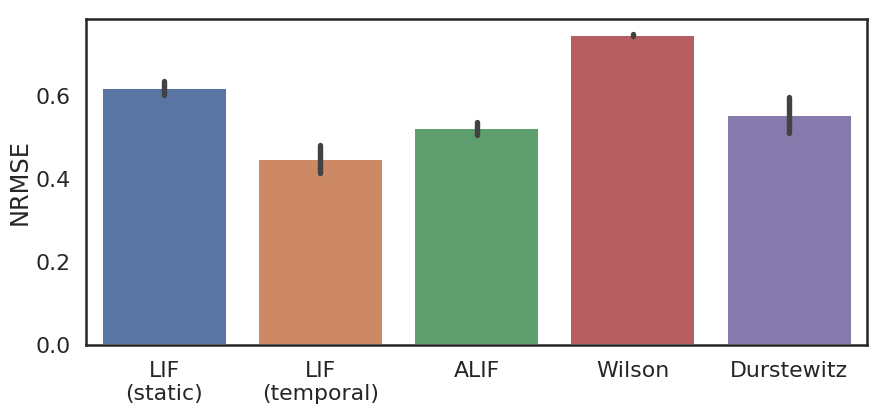

In [28]:
nrmses_none_fx = trials_fx(
    fx=fx, n_neurons=10, t=1, tau=0.1, dt=0.001, maxiter_gainbias=1, optimize_h='none', n_trials=2, pe=False)

### lstsq filter optimization

optimizing gain and bias
<Connection pre_durstewitz>


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


<Connection durstewitz_durstewitz2>


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus iteration 0, nonzero d 10, tau=[0.04499]: 
taus iteration 0, nonzero d 10, tau=[0.08958]: 
taus iteration 0, nonzero d 10, tau=[0.05164]: 
taus iteration 0, nonzero d 10, tau=[0.05613]: 
optimizing filters and decoders


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus iteration 0, nonzero d 6, tau=[0.04074]: 
taus iteration 0, nonzero d 6, tau=[0.03668]: 
taus iteration 0, nonzero d 10, tau=[0.10519]: 
taus iteration 0, nonzero d 1, tau=[0.05263]: 
running experimental trials


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


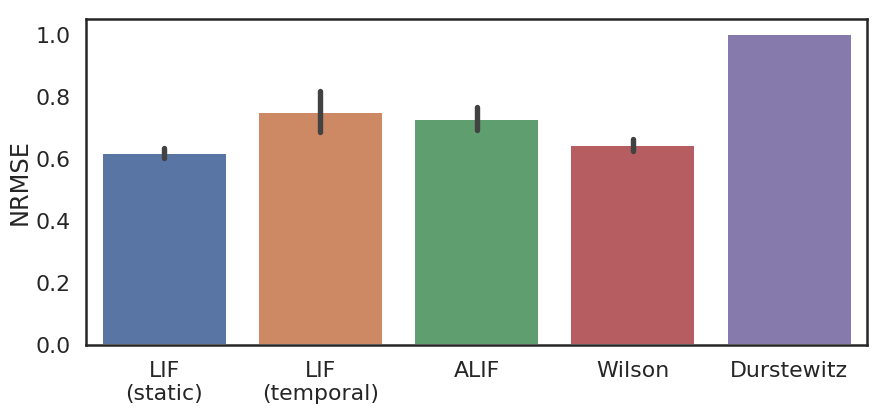

In [36]:
nrmses_lstsq_fx = trials_fx(
    fx=fx, n_neurons=10, t=1, tau=0.1, dt=0.001, maxiter_gainbias=1, optimize_h='lstsq', n_trials=2, pe=False)

### hyperopt filter optimization

optimizing gain and bias
<Connection pre_durstewitz>


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Connection durstewitz_durstewitz2>
iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

optimizing filters and decoders


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

running experimental trials


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


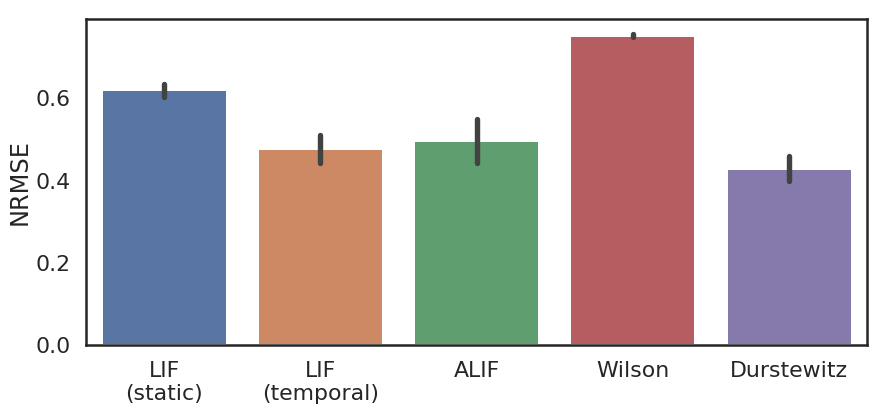

In [39]:
nrmses_hyperopt_fx = trials_fx(
    fx=fx, n_neurons=10, t=1, tau=0.1, dt=0.001, maxiter_gainbias=1, optimize_h='hyperopt', n_trials=2, pe=False)

In [ ]:
n_neurons = 100
tau = 0.1
# dt = 0.001
dt = 0.000025
d_lif = np.zeros((n_neurons, 1))
d_alif = np.zeros((n_neurons, 1))
d_wilson = np.zeros((n_neurons, 1))
d_durstewitz = np.zeros((n_neurons, 1))
def fx(x):
    return np.square(x)

data_fx = go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz, n_neurons=n_neurons, tau=tau, dt=dt, maxiter=10)

In [ ]:
h = Lowpass(tau)
d_lif = update_d(data_fx['tar'], data_fx['lif'], h, lambda_d=1e-1, tau=tau, dt=dt)
d_alif = update_d(data_fx['tar'], data_fx['alif'], h, lambda_d=1e-1, tau=tau, dt=dt)
d_wilson = update_d(data_fx['tar'], data_fx['wilson'], h, lambda_d=1e-1, tau=tau, dt=dt)
d_durstewitz = update_d(data_fx['tar'], data_fx['durstewitz'], h, lambda_d=1e-1, tau=tau, dt=dt)

a_lif = h.filt(data_fx['lif'], dt=dt)
a_alif = h.filt(data_fx['alif'], dt=dt)
a_wilson = h.filt(data_fx['wilson'], dt=dt)
a_durstewitz = h.filt(data_fx['durstewitz'], dt=dt)

xhat_lif = np.dot(a_lif, d_lif)
xhat_alif = np.dot(a_alif, d_alif)
xhat_wilson = np.dot(a_wilson, d_wilson)
xhat_durstewitz = np.dot(a_durstewitz, d_durstewitz)

target = h.filt(data_fx['tar'], dt=dt)
nrmse_lif = nrmse(xhat_lif, target=target)
nrmse_alif = nrmse(xhat_alif, target=target)
nrmse_wilson = nrmse(xhat_wilson, target=target)
nrmse_durstewitz = nrmse(xhat_durstewitz, target=target)

fig, ax = plt.subplots(figsize=((12, 8)))
ax.plot(data_fx['times'], target, linestyle="--", label='target')
ax.plot(data_fx['times'], xhat_lif, label='LIF, nrmse=%.3f' %nrmse_lif)
ax.plot(data_fx['times'], xhat_alif, label='ALIF, nrmse=%.3f' %nrmse_alif)
ax.plot(data_fx['times'], xhat_wilson, label='Wilson, nrmse=%.3f' %nrmse_wilson)
ax.plot(data_fx['times'], xhat_durstewitz, label='Durstewitz, nrmse=%.3f' %nrmse_durstewitz)
ax.set(xlabel='time (s)', ylabel=r'$\mathbf{x}$')
plt.legend(loc='upper right')
fig.show()

In [ ]:
data_fx2 = go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz, n_neurons=n_neurons, tau=tau, dt=dt,
    gain_bias_dict=data_fx['gain_bias_dict'], opt=False)

In [ ]:
h = Lowpass(tau)
d_lif2 = update_d(data_fx['tar2'], data_fx2['lif2'], h, lambda_d=1e-1, tau=tau, dt=dt)
d_alif2 = update_d(data_fx['tar2'], data_fx2['alif2'], h, lambda_d=1e-1, tau=tau, dt=dt)
d_wilson2 = update_d(data_fx['tar2'], data_fx2['wilson2'], h, lambda_d=1e-1, tau=tau, dt=dt)
d_durstewitz2 = update_d(data_fx['tar2'], data_fx2['durstewitz2'], h, lambda_d=1e-1, tau=tau, dt=dt)

In [ ]:
data_fx2 = go_fx(fx, d_lif, d_alif, d_wilson, d_durstewitz, n_neurons=n_neurons, tau=tau, dt=dt,
    gain_bias_dict=data_fx['gain_bias_dict'], opt=False,
    stim_func=lambda t: np.cos(t))

In [ ]:
a_lif2 = h.filt(data_fx2['lif2'], dt=dt)
a_alif2 = h.filt(data_fx2['alif2'], dt=dt)
a_wilson2 = h.filt(data_fx2['wilson2'], dt=dt)
a_durstewitz2 = h.filt(data_fx2['durstewitz2'], dt=dt)

xhat_lif2 = np.dot(a_lif2, d_lif2)
xhat_alif2 = np.dot(a_alif2, d_alif2)
xhat_wilson2 = np.dot(a_wilson2, d_wilson2)
xhat_durstewitz2 = np.dot(a_durstewitz2, d_durstewitz2)

target2 = h.filt(data_fx2['tar2'], dt=dt)
nrmse_lif2 = nrmse(xhat_lif2, target=target2)
nrmse_alif2 = nrmse(xhat_alif2, target=target2)
nrmse_wilson2 = nrmse(xhat_wilson2, target=target2)
nrmse_durstewitz2 = nrmse(xhat_durstewitz2, target=target2)

fig, ax = plt.subplots(figsize=((12, 8)))
# ax.plot(data_fx2['times'], target, linestyle="--", label='target')
ax.plot(data_fx2['times'], target2, linestyle="--", label='target2')
ax.plot(data_fx2['times'], xhat_lif2, label='LIF, nrmse=%.3f' %nrmse_lif2)
ax.plot(data_fx2['times'], xhat_alif2, label='ALIF, nrmse=%.3f' %nrmse_alif2)
ax.plot(data_fx2['times'], xhat_wilson2, label='Wilson, nrmse=%.3f' %nrmse_wilson2)
ax.plot(data_fx2['times'], xhat_durstewitz2, label='Durstewitz, nrmse=%.3f' %nrmse_durstewitz2)
ax.set(xlabel='time (s)', ylabel=r'$\mathbf{x}$')
plt.legend(loc='upper right')
fig.show()

## Integrator

In [49]:
def go_integrator(d_lif, d_alif, d_wilson, d_durstewitz, h_lif, h_alif, h_wilson, h_durstewitz,
        n_neurons=10, t=4*np.pi, max_rates=Uniform(20, 40), intercepts=Uniform(-0.8, 0.8),
        supv=0, maxiter_gainbias=5, gain_bias_dict=dict(), seed=0, dt=0.000025, tau=0.1, n_neurons_pre=100,
        reg=1e-1, opt=False, pt=False, stim_func=lambda t: np.sin(t)):

    solver_nef = LstsqL2(reg=reg)
    solver_lif = NoSolver(d_lif)
    solver_alif = NoSolver(d_alif)
    solver_wilson = NoSolver(d_wilson)
    solver_durstewitz = NoSolver(d_durstewitz)

    norm_stim, norm_int = norms(t, dt=dt, stim_func=stim_func)

    with nengo.Network(seed=0) as model:
        
        # Ensembles
        u = nengo.Node(stim_func)
        pre_u = nengo.Ensemble(n_neurons_pre, 1, max_rates=max_rates,
            seed=0, radius=norm_stim, label='pre_u')
        pre_x = nengo.Ensemble(n_neurons_pre, 1, max_rates=max_rates,
            seed=0, label='pre_x')
        nef = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif')
        lif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif')
        alif = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=0, label='alif')
        wilson = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=WilsonEuler(), seed=0, label='wilson')
        durstewitz = nengo.Ensemble(n_neurons, 1,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=DurstewitzNeuron(), seed=1, label='durstewitz')
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # Normal connections
        nengo.Connection(u, pre_u, synapse=None, transform=1.0/norm_int, seed=0)
        nengo.Connection(u, pre_x, synapse=1/s, transform=1.0/norm_int, seed=0)
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_int)

        # Feedforward connections
        pre_u_nef = nengo.Connection(pre_u, nef, synapse=Lowpass(tau), transform=tau,
            solver=LstsqL2(reg=reg), seed=0, label='pre_u_nef')
        pre_u_lif = nengo.Connection(pre_u, lif, synapse=Lowpass(tau), transform=tau,
            solver=LstsqL2(reg=reg), seed=0, label='pre_u_lif')
        pre_u_alif = nengo.Connection(pre_u, alif, synapse=Lowpass(tau), transform=tau,
            solver=LstsqL2(reg=reg), seed=0, label='pre_u_alif')
        pre_u_wilson = nengo.Connection(pre_u, wilson, synapse=Lowpass(tau), transform=tau,
            solver=LstsqL2(reg=reg), seed=0, label='pre_u_wilson')
        pre_u_durstewitz = nengo.Connection(pre_u, durstewitz, synapse=Lowpass(tau), transform=tau,
            solver=LstsqL2(reg=reg), seed=0, label='pre_u_durstewitz')
        
        # Feedback Connections
        if supv:
            pre_x_lif = nengo.Connection(pre_x, lif, synapse=Lowpass(tau),
                solver=LstsqL2(reg=reg), seed=0, label='pre_x_lif')
            pre_x_alif = nengo.Connection(pre_x, alif, synapse=Lowpass(tau),
                solver=LstsqL2(reg=reg), seed=0, label='pre_x_alif')
            pre_x_wilson = nengo.Connection(pre_x, wilson, synapse=Lowpass(tau),
                solver=LstsqL2(reg=reg), seed=0, label='pre_x_wilson')
            pre_x_durstewitz = nengo.Connection(pre_x, durstewitz, synapse=Lowpass(tau),
                solver=LstsqL2(reg=reg), seed=0, label='pre_x_durstewitz')
        else:
            lif_lif = nengo.Connection(lif, lif, synapse=h_lif,
                solver=solver_lif, seed=0, label='lif_lif')
            alif_alif = nengo.Connection(alif, alif, synapse=h_alif,
                solver=solver_alif, seed=0, label='alif_alif')
            wilson_wilson = nengo.Connection(wilson, wilson, synapse=h_wilson,
                solver=solver_wilson, seed=0, label='wilson_wilson')
            durstewitz_durstewitz = nengo.Connection(durstewitz, durstewitz, synapse=h_durstewitz,
                solver=solver_durstewitz, seed=0, label='durstewitz_durstewitz')
        nef_nef = nengo.Connection(nef, nef, synapse=Lowpass(tau),
            solver=solver_nef, seed=0, label='nef_nef')

        # Probes
        p_stim = nengo.Probe(u, synapse=None)
        p_target = nengo.Probe(tar, synapse=None)
        p_nef = nengo.Probe(nef, synapse=tau)
        p_lif = nengo.Probe(lif.neurons, synapse=None)
        p_alif = nengo.Probe(alif.neurons, synapse=None)
        p_wilson = nengo.Probe(wilson.neurons, synapse=None)
        p_durstewitz = nengo.Probe(durstewitz.neurons, synapse=None)

    if opt:
        gain_bias_dict = conn_opt([pre_u_durstewitz], maxiter=maxiter_gainbias, pt=pt, stim_func=stim_func)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pre_u_durstewitz.gain = gain_bias_dict['pre_u_durstewitz']['gain']
        pre_u_durstewitz.bias = gain_bias_dict['pre_u_durstewitz']['bias'] * tau
        if supv:
            pre_x_durstewitz.gain = gain_bias_dict['pre_u_durstewitz']['gain']
            pre_x_durstewitz.bias = gain_bias_dict['pre_u_durstewitz']['bias']
        else:
            durstewitz_durstewitz.gain = gain_bias_dict['pre_u_durstewitz']['gain']
            durstewitz_durstewitz.bias = gain_bias_dict['pre_u_durstewitz']['bias']

    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        reset_neuron(sim) 
        
    return dict(
        times=sim.trange(sample_every=dt),
        stim=1.0/norm_int*sim.data[p_stim],
        tar=sim.data[p_target],
        nef=sim.data[p_nef],
        lif=sim.data[p_lif],
        alif=sim.data[p_alif],
        wilson=sim.data[p_wilson],
        durstewitz=sim.data[p_durstewitz],
        gain_bias_dict=gain_bias_dict)

In [50]:
def trials_integrator(n_neurons, t, tau, dt, maxiter_gainbias, optimize_h, n_trials, pe=False, order=1):
    h_lif = Lowpass(tau)
    h_alif = Lowpass(tau)
    h_wilson = Lowpass(tau)
    h_durstewitz = Lowpass(tau)
    h_tar = Lowpass(tau)
    d_lif = np.zeros((n_neurons, 1))
    d_alif = np.zeros((n_neurons, 1))
    d_wilson = np.zeros((n_neurons, 1))
    d_durstewitz = np.zeros((n_neurons, 1))

    print('optimizing gain and bias')
    data_int = go_integrator(d_lif, d_alif, d_wilson, d_durstewitz, h_lif, h_alif, h_wilson, h_durstewitz, 
        n_neurons=n_neurons, tau=tau, dt=dt, maxiter_gainbias=maxiter_gainbias, opt=True)

    if optimize_h != 'lstsq' and optimize_h != 'hyperopt':
        d_lif = update_d(data_int['tar'], data_int['lif'], h_lif, h_tar, lambda_d=1e-1, dt=dt)
        d_alif = update_d(data_int['tar'], data_int['alif'], h_alif, h_tar, lambda_d=1e-1, dt=dt)
        d_wilson = update_d(data_int['tar'], data_int['wilson'], h_wilson, h_tar, lambda_d=1e-1, dt=dt)
        d_durstewitz = update_d(data_int['tar'], data_int['durstewitz'], h_durstewitz, h_tar, lambda_d=1e-1, dt=dt)
    elif optimize_h == 'lstsq':
        h_lif, d_lif = update_h_lstsq(
            data_int['stim'],
            data_int['tar'],
            data_int['lif'],
            order=order, dt=dt)
        h_alif, d_alif = update_h_lstsq(
            data_int['stim'],
            data_int['tar'],
            data_int['alif'],
            order=order, dt=dt)
        h_wilson, d_wilson = update_h_lstsq(
            data_int['stim'],
            data_int['tar'],
            data_int['wilson'],
            order=order, dt=dt)
        h_durstewitz, d_durstewitz = update_h_lstsq(
            data_int['stim'],
            data_int['tar'],
            data_int['durstewitz'],
            order=order, dt=dt)
    elif optimize_h == 'hyperopt':
        h_lif, d_lif = update_h_hyperopt(
            h_tar.filt(data_int['tar'], dt=dt),
            data_int['lif'],
            order=order, dt=dt)
        h_alif, d_alif = update_h_hyperopt(
            h_tar.filt(data_int['tar'], dt=dt),
            data_int['alif'],
            order=order, dt=dt)
        h_wilson, d_wilson = update_h_hyperopt(
            h_tar.filt(data_int['tar'], dt=dt),
            data_int['wilson'],
            order=order, dt=dt)
        h_durstewitz, d_durstewitz = update_h_hyperopt(
            h_tar.filt(data_int['tar'], dt=dt),
            data_int['durstewitz'],
            order=order, dt=dt)   
        
    print('running experimental trials')
    nrmses = np.zeros((5, n_trials))
    for trial in range(n_trials):
        stim_func = nengo.processes.WhiteSignal(period=2*np.pi, high=1, rms=0.5, seed=trial)
        data_int_test = go_integrator(d_lif, d_alif, d_wilson, d_durstewitz,h_lif, h_alif, h_wilson, h_durstewitz, 
            n_neurons=n_neurons, tau=tau, dt=dt,
            gain_bias_dict=data_int['gain_bias_dict'], opt=False, stim_func=stim_func)
        a_lif = h_lif.filt(data_int_test['lif'], dt=dt)
        a_alif = h_alif.filt(data_int_test['alif'], dt=dt)
        a_wilson = h_wilson.filt(data_int_test['wilson'], dt=dt)
        a_durstewitz = h_durstewitz.filt(data_int_test['durstewitz'], dt=dt)
        xhat_nef = data_int_test['nef']
        xhat_lif = np.dot(a_lif, d_lif)
        xhat_alif = np.dot(a_alif, d_alif)
        xhat_wilson = np.dot(a_wilson, d_wilson)
        xhat_durstewitz = np.dot(a_durstewitz, d_durstewitz)
        target = h_tar.filt(data_int_test['tar'], dt=dt)
        nrmses[0, trial] = nrmse(xhat_nef, target=target)
        nrmses[1, trial] = nrmse(xhat_lif, target=target)
        nrmses[2, trial] = nrmse(xhat_alif, target=target)
        nrmses[3, trial] = nrmse(xhat_wilson, target=target)
        nrmses[4, trial] = nrmse(xhat_durstewitz, target=target)
        if pe:
            fig, ax = plt.subplots(figsize=((12, 8)))
            ax.plot(data_int_test['times'], target, linestyle="--", label='target')
            ax.plot(data_int_test['times'], xhat_nef, label='NEF, nrmse=%.3f' %nrmses[0, trial])
            ax.plot(data_int_test['times'], xhat_lif, label='LIF, nrmse=%.3f' %nrmses[1, trial])
            ax.plot(data_int_test['times'], xhat_alif, label='ALIF, nrmse=%.3f' %nrmses[2, trial])
            ax.plot(data_int_test['times'], xhat_wilson, label='Wilson, nrmse=%.3f' %nrmses[3, trial])
            ax.plot(data_int_test['times'], xhat_durstewitz, label='Durstewitz, nrmse=%.3f' %nrmses[4, trial])
            ax.set(xlabel='time (s)', ylabel=r'$\mathbf{x}$')
            plt.legend(loc='upper right')
            fig.show()
    nt_names =  ['LIF\n(static)', 'LIF\n(temporal)', 'ALIF', 'Wilson', 'Durstewitz']
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    sns.barplot(data=nrmses.T)
    ax.set(ylabel='NRMSE')
    plt.xticks(np.arange(len(nt_names)), tuple(nt_names), rotation=0)
    plt.show()
    return nrmses

### no filter optimization

optimizing gain and bias


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


<Connection pre_u_durstewitz>
iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

running experimental trials


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


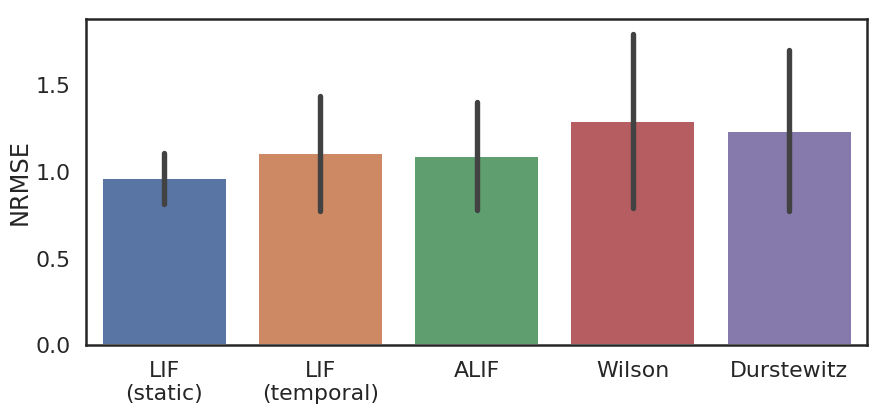

In [51]:
nrmses_none_int = trials_integrator(
    n_neurons=10, t=1, tau=0.1, dt=0.001, maxiter_gainbias=1, optimize_h='none', n_trials=2, pe=False)

optimizing gain and bias


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


<Connection pre_u_durstewitz>
iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus iteration 0, nonzero d 6, tau=[0.07052]: 
taus iteration 0, nonzero d 6, tau=[0.04955]: 
taus iteration 0, nonzero d 10, tau=[0.09883]: 
taus iteration 0, nonzero d 4, tau=[0.08653]: 
running experimental trials


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


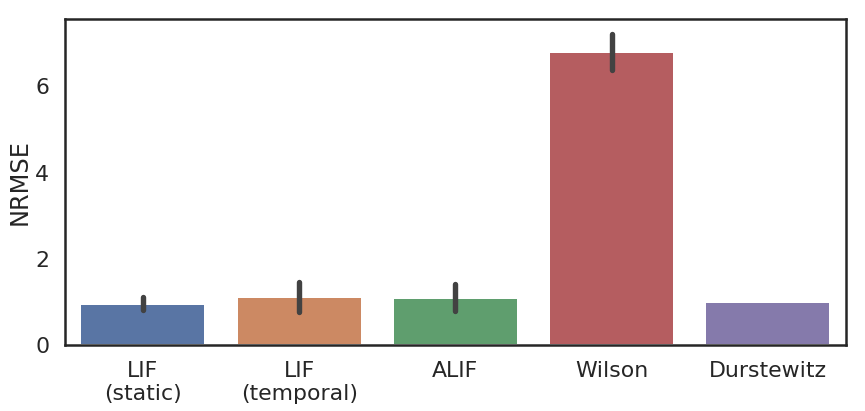

In [52]:
nrmses_lstsq_int = trials_integrator(
    n_neurons=10, t=1, tau=0.1, dt=0.001, maxiter_gainbias=1, optimize_h='lstsq', n_trials=2, pe=False)

optimizing gain and bias


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


<Connection pre_u_durstewitz>
iteration 0, remaining neurons 10


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

running experimental trials


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


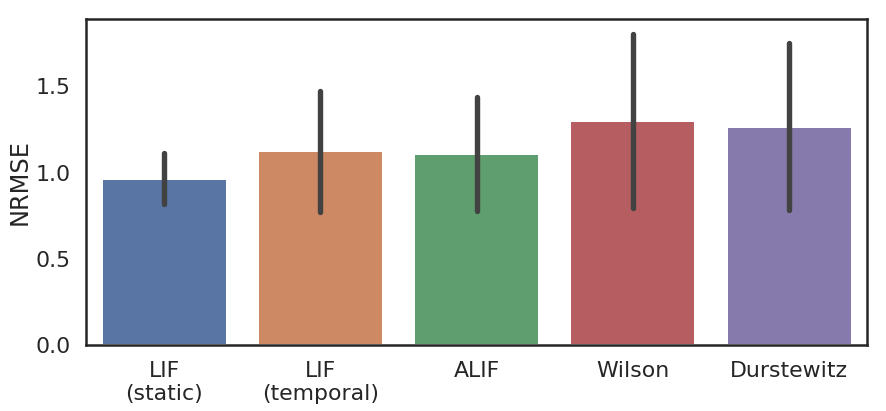

In [53]:
nrmses_hyperopt_int = trials_integrator(
    n_neurons=10, t=1, tau=0.1, dt=0.001, maxiter_gainbias=1, optimize_h='hyperopt', n_trials=2, pe=False)